# **Bagging and random forest**
Next, we're gonna talk about bagging and my favorite algorithm is a random forest. Despite the fact that these are some of very first algorithms among the family of ensembles, they are still widely popular due to their simplicity and efficiency, often not inferior to boostings in terms of accuracy. About what it is and how it works, further in the article.

### **Classifiers and regressors with voting**

Suppose there are several classifiers trained on the same data. A simple way to create a stronger classifier would be majority aggregation of predictions based on them, that is, the final prdiction would be the class with the most votes. This algorithm is called the *hard voting classifier*.

If the basic classifiers are able to estimate the probabilities of classes, that is, they support the "predict_proba" method, then you can create a classifier that predicts the class with the highest probability, averaged over all the basic classifiers. This algorithm is called the *soft voting classifier* and has higher accuracy by giving more weight to votes with high confidence.

In the case of regression, the predictions of the basic algorithms are averaged and such algorithm is called a *voting regressor*.

In scikit-learn, classifiers and regressors with voting are presented in the form of *VotingClassifier* and *VotingRegressor* classes and, in general, perform better than each basic model individually, but they still do not work well with outliers and are subject to overfitting by training each model included in them on the same dataset.

### **Bagging and pasting**
A more advanced approach involves the repeated use of the same basic model trained on different random subsets of the training dataset. If sampling is performed with a return, this approach is called *bagging (short for bootstrap aggregating)*, and in the case of sampling without replacement, *pasting*.

In statistics, the procedure for generating a repeated sample with a return is called *bootstrapping*. An example is given below.

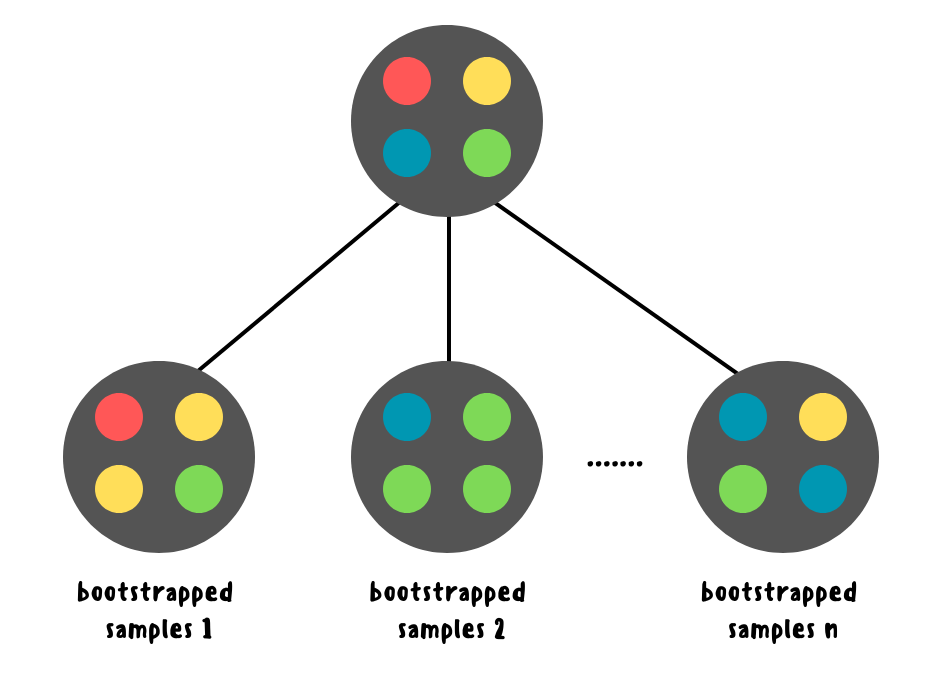

After repeatedly training n identical basic models on bootstrapped samples, the resulting ensemble produces a final prediction by simply aggregating the predictions of the basic models. In the case of classification, the aggregation function is a *statistical mode*, and in the case of regression, an *arithmetic mean*. This approach reduces both bias and variance.

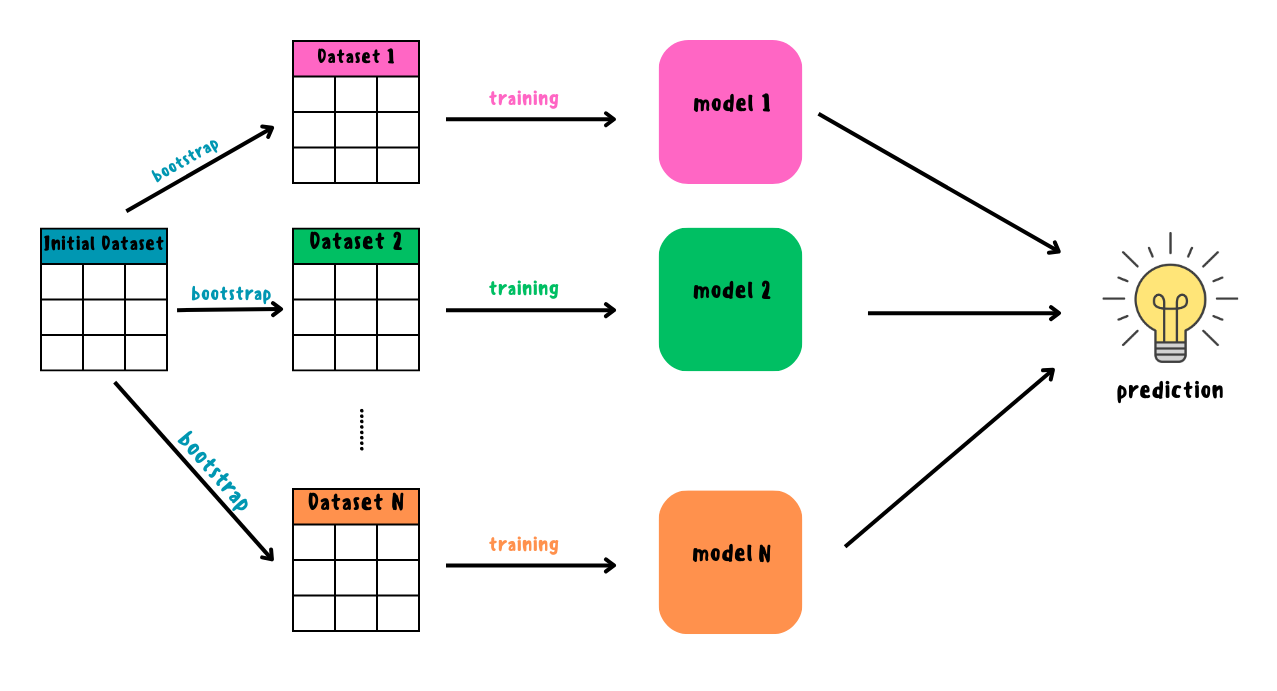

As you can see, the basic models can be trained and make predictions in parallel, which makes bagging and pasting well-scalable methods. This is one of the reasons for their widespread use. In the scikit-learn implementation for bagging, *parallelization is implemented using the joblib library*, and the number of cores used is set using the "n_jobs" parameter (with a value of -1, all available cores are used). In our manual implementation, we will also apply parallel learning using this library.

In general, bagging works slightly better than pasting due to the fact that bootstrapping creates more distinct training samples.

### **Evaluation on unused samples**
Considering that during bagging, a return sample is performed, controlled by the "bootstrap=True" parameter (in the case of False, pasting is performed), then on average about 63% of the m training samples will be selected for each base model. The remaining 37% are called *out-of-bag samples* (or oob), which can be easily proved:

$$lim_{m \to \infty}(1 - \frac{1}{m})^{m} = \frac{1}{e} \approx 0.37$$

It is also worth noting that such 37% percent of the samples will be different for each basic model in the ensemble.

Given that the basic models do not use oob samples during training, they can be used as a separate test set or during cross-validation, and the entire ensemble can be evaluated by averaging the oob score of each basic model by setting the parameter "oob_score=True".

### **Methods of random patches and random subspaces**
Randomly selecting training samples and features at once is called the *random patches method*, and sampling features (bootstrap_features=True and/or max_features < 1.0) while preserving all training samples is called the *random subspaces method*. These methods are especially useful when using a large amount of high-dimensional data.

It is worth noting that feature sampling allows you to create more distinct base models, slightly increasing the bias and reducing the variance.

### **Random forest and especially random trees**
A random forest is a special, optimized case of bagging and pasting based on decision trees.

The algorithm is constructed as follows:
- 1) initially, n bootstrapped samples are constructed, as a rule, by the method of random subspaces;
- 2) n trees are trained in parallel on the received samples and make predictions on X_test;
 3) the obtained predictions are aggregated by the mode in the case of classification and the average in the case of regression.

**Formulas for calculations**:

$\hat{f}_{rf}^{B} (x) = \frac{1}{B} \sum\limits_{b=1}^{B} T_{b} (x) \ - \ $ rf-prediction for regression

$\hat{C}_{rf}^{B} (x) = {majority \ vote}$ {$\hat{C}_{b} (x)$} $_{1}^{B} \ - \ $ rf-prediction for classification

$T_{b} (x) \ - \ $ output of a b-th bootstrapped tree

$\hat{C}_{b} (x) \ - \ $ class prediction of a b-th bootstrapped tree

$m = \sqrt{p} \ - \ $ max features for classification

$m = \frac{p}{3}, \ - \ $ max features for regression

$m = p \ - \ $ sklearn version for regression

$p \ - \ $ number of all features in a datset

Trees in a random forest can be made even more random by choosing random thresholds for each feature instead of searching for the best one, as implemented in CART. A forest with such random trees is called **an extremely randomized trees ensemble or extra-trees**. In extra-trees, each tree is even more distinct from each other than in a random forest, which also increases bias and reduces variance. In addition, such trees get trained much faster.

### **Feature importance**
Another useful feature of a random forest is the measurement of the relative importance of each feature, based on how much impurity decreases in the nodes of the tree on average using the current feature. Simply put, feature importance is a weighted average, where the weight of each node corresponds to the number of samples associated with it: the greater the weight of the feature, the greater its contribution to the overall accuracy of the model.

It is worth noting that in machine learning there are more advanced methods of interpreting model results, for example, [SHAP](https://medium.com/@bneeraj026/shap-feature-importance-deep-dive-1b96a9d43d08) or [LIME](https://coderzcolumn.com/tutorials/machine-learning/how-to-use-lime-to-understand-sklearn-models-predictions).

### **Python implementation from scratch**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_percentage_error
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import BaggingClassifier, VotingClassifier, ExtraTreesClassifier
from joblib import Parallel, delayed
from mlxtend.plotting import plot_decision_regions

In [2]:
class RandomForest:
    def __init__(self, regression=False, n_estimators=100, max_depth=None,
                 max_features=1.0, n_jobs=-1, random_state=0, ccp_alpha=0.0):
        self.regression = regression
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.n_jobs = n_jobs
        self.random_state = random_state
        self.ccp_alpha = ccp_alpha
        self.trained_trees_info = []
        self.general_random = np.random.RandomState(self.random_state)

    #bootstrapping with random subspaces method
    def _rsm_bootstrapping(self, X, y):
        n_samples, n_features = X.shape
        if self.regression:
            max_features = self.max_features * n_features
        else:
            max_features = np.sqrt(n_features)

        sample_indexes = self.general_random.choice(n_samples, n_samples)
        features = self.general_random.choice(X.columns, round(max_features))
        X_b, y_b = X.iloc[sample_indexes][features], y.iloc[sample_indexes]

        return X_b, y_b

    def _train_tree(self, X, y):
        if self.regression:
            tree = DecisionTreeRegressor(max_depth=self.max_depth,
                                         random_state=self.random_state,
                                         ccp_alpha=self.ccp_alpha)
        else:
            tree = DecisionTreeClassifier(max_depth=self.max_depth,
                                          random_state=self.random_state,
                                          ccp_alpha=self.ccp_alpha)

        return tree.fit(X, y), X.columns

    def fit(self, X, y):
        boot_data = (self._rsm_bootstrapping(X, y) for _ in range(self.n_estimators))
        train_trees = (delayed(self._train_tree)(X_b, y_b) for X_b, y_b in boot_data)
        self.trained_trees_info = Parallel(n_jobs=self.n_jobs)(train_trees)

    def predict(self, samples):
        prediction = (delayed(tree_i.predict)(samples[tree_i_features])
                      for (tree_i, tree_i_features) in self.trained_trees_info)

        trees_predictions = pd.DataFrame(Parallel(n_jobs=self.n_jobs)(prediction))

        if self.regression:
            forest_prediction = trees_predictions.mean(axis=0)
        else:
            forest_prediction = trees_predictions.mode(axis=0).iloc[0]

        return np.array(forest_prediction)

In [3]:
def decision_boundary_plot(X, y, X_train, y_train, clf, feature_indexes, title=None):
    feature1_name, feature2_name = X.columns[feature_indexes]
    X_feature_columns = X.values[:, feature_indexes]
    X_train_feature_columns = X_train.values[:, feature_indexes]
    clf.fit(X_train_feature_columns, y_train.values)

    plot_decision_regions(X=X_feature_columns, y=y.values, clf=clf)
    plt.xlabel(feature1_name)
    plt.ylabel(feature2_name)
    plt.title(title)

### **Uploading datasets**
[Glass Classification](https://www.kaggle.com/datasets/uciml/glass) dataset will be used to train models where it is necessary to correctly determine the type of glass by its characteristics. In the case of regression Diabetes dataset from scikit-learn is used.

In [4]:
df_path = "/content/drive/MyDrive/glass.csv"
glass_df = pd.read_csv(df_path)
X1, y1 = glass_df.iloc[:, :-1], glass_df.iloc[:, -1]
y1 = pd.Series(LabelEncoder().fit_transform(y1))
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, random_state=0)
print(glass_df)

          RI     Na    Mg    Al     Si     K    Ca    Ba   Fe  Type
0    1.52101  13.64  4.49  1.10  71.78  0.06  8.75  0.00  0.0     1
1    1.51761  13.89  3.60  1.36  72.73  0.48  7.83  0.00  0.0     1
2    1.51618  13.53  3.55  1.54  72.99  0.39  7.78  0.00  0.0     1
3    1.51766  13.21  3.69  1.29  72.61  0.57  8.22  0.00  0.0     1
4    1.51742  13.27  3.62  1.24  73.08  0.55  8.07  0.00  0.0     1
..       ...    ...   ...   ...    ...   ...   ...   ...  ...   ...
209  1.51623  14.14  0.00  2.88  72.61  0.08  9.18  1.06  0.0     7
210  1.51685  14.92  0.00  1.99  73.06  0.00  8.40  1.59  0.0     7
211  1.52065  14.36  0.00  2.02  73.42  0.00  8.44  1.64  0.0     7
212  1.51651  14.38  0.00  1.94  73.61  0.00  8.48  1.57  0.0     7
213  1.51711  14.23  0.00  2.08  73.36  0.00  8.62  1.67  0.0     7

[214 rows x 10 columns]


In [5]:
X2, y2 = load_diabetes(return_X_y=True, as_frame=True)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state=0)
print(X2, y2, sep='\n')

          age       sex       bmi        bp        s1        s2        s3  \
0    0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1   -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2    0.085299  0.050680  0.044451 -0.005670 -0.045599 -0.034194 -0.032356   
3   -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4    0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   
..        ...       ...       ...       ...       ...       ...       ...   
437  0.041708  0.050680  0.019662  0.059744 -0.005697 -0.002566 -0.028674   
438 -0.005515  0.050680 -0.015906 -0.067642  0.049341  0.079165 -0.028674   
439  0.041708  0.050680 -0.015906  0.017293 -0.037344 -0.013840 -0.024993   
440 -0.045472 -0.044642  0.039062  0.001215  0.016318  0.015283 -0.028674   
441 -0.045472 -0.044642 -0.073030 -0.081413  0.083740  0.027809  0.173816   

           s4        s5        s6  
0   -0.002592  0.019907 -0.017646  
1  

### **Models training and evaluation of the obtained results**
As expected, bagging and random forest showed an increase in accuracy compared to the decision tree. The difference is even more noticeable with the use extra-trees, but the voting classifier did not give an increase in accuracy.

It is also worth noting that especially extra-trees do not always benefit in terms of accuracy in comparison with a random forest, and the only reliable way to find out which algorithm is better is to directly compare them with the selection of different hyperparameters.

The obtained results and plots of the decision boundaries for each algorithm are shown below.

**Random Forest for classification**

In [6]:
random_forest_classifier = RandomForest(random_state=0)
random_forest_classifier.fit(X1_train, y1_train)
rf_clf_pred_res = random_forest_classifier.predict(X1_test)
rf_clf_accuracy = accuracy_score(rf_clf_pred_res, y1_test)
print(rf_clf_pred_res)
print(f'rf_clf accuracy: {rf_clf_accuracy}')

sk_random_forest_classifier = RandomForestClassifier(random_state=0)
sk_random_forest_classifier.fit(X1_train, y1_train)
sk_rf_clf_pred_res = sk_random_forest_classifier.predict(X1_test)
sk_rf_clf_accuracy = accuracy_score(sk_rf_clf_pred_res, y1_test)
print(sk_rf_clf_pred_res)
print(f'sk_rf_clf accuracy: {sk_rf_clf_accuracy}')

[5 0 1 4 3 1 0 1 1 1 0 0 1 1 1 5 0 1 2 0 1 0 5 5 0 0 5 0 1 1 0 0 1 0 0 0 0
 0 0 5 1 4 1 0 1 1 0 1 0 1 0 1 5 0]
rf_clf accuracy: 0.7222222222222222
[5 0 1 4 3 1 0 1 1 1 1 0 1 1 1 5 2 1 2 1 3 0 5 5 0 0 5 0 1 1 0 0 1 0 0 0 0
 0 0 5 3 4 1 0 1 1 0 1 0 1 0 1 5 0]
sk_rf_clf accuracy: 0.7037037037037037


**Random Forest for regression**

In [7]:
random_forest_regressor = RandomForest(regression=True, random_state=0)
random_forest_regressor.fit(X2_train, y2_train)
rf_reg_pred_res = random_forest_regressor.predict(X2_test)
mape = mean_absolute_percentage_error(rf_reg_pred_res, y2_test)
print(f'mape: {mape}')
print(rf_reg_pred_res)

sk_random_forest_regressor = RandomForestRegressor(random_state=0)
sk_random_forest_regressor.fit(X2_train, y2_train)
sk_rf_reg_pred_res = sk_random_forest_regressor.predict(X2_test)
sk_mape = mean_absolute_percentage_error(sk_rf_reg_pred_res, y2_test)
print(f'sk_mape: {sk_mape}')
print(sk_rf_reg_pred_res)

mape: 0.3162321058884571
[233.89 236.14 160.42 114.39 182.3  233.59 101.64 231.75 134.16 209.1
 157.81 157.92 148.37 112.27 276.42 106.68 148.94  82.27 110.39 221.53
 163.31 132.82 158.98 114.09 201.66 187.82 144.77  81.82 194.05 173.86
 174.28  84.67 135.73 162.31 148.59 188.1  163.34 144.86 108.44 212.66
 111.   159.73 123.71 173.85 177.94  87.07 122.24 141.52 111.05 220.33
 159.28  75.79 156.81 173.54 234.88 204.58 180.04 118.67 146.71 167.36
 216.98 153.32 132.07 105.45 239.33 150.75  93.58 224.83 200.27 112.72
  86.13 135.73 117.98 135.13 136.06 180.59 137.36 225.1  244.43 209.96
 133.33 210.47  78.8  240.79 124.75  96.83 144.62 189.53 112.04 146.64
 103.61 114.46  95.39 186.43 105.3   90.85 232.33 216.32 143.46 156.55
 156.59 112.41 176.95 100.51 227.5  143.1  213.6  255.85 106.35  92.22
 237.11]
sk_mape: 0.3313513936725928
[250.61 251.57 169.22  92.96 208.8  261.45  91.43 240.08 128.06 240.07
 167.75 151.67 127.6   95.09 289.77  90.21 162.    77.62 107.74 220.32
 186.06 125.12 1

<Axes: >

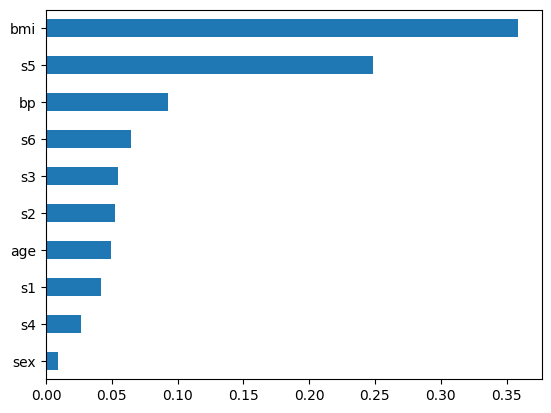

In [8]:
importances = sk_random_forest_regressor.feature_importances_
feature_importances = pd.Series(importances, index=X2_train.columns)
feature_importances.sort_values(ascending=True).plot(kind='barh')

**DecisionTreeClassifier**

tree accuracy: 0.6111111111111112
[5 0 1 1 3 1 0 1 1 1 1 2 1 1 1 5 2 1 0 1 3 0 5 3 0 0 5 0 0 1 0 0 1 2 0 0 0
 2 0 5 3 4 1 0 1 1 0 1 0 1 0 4 5 2]


/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


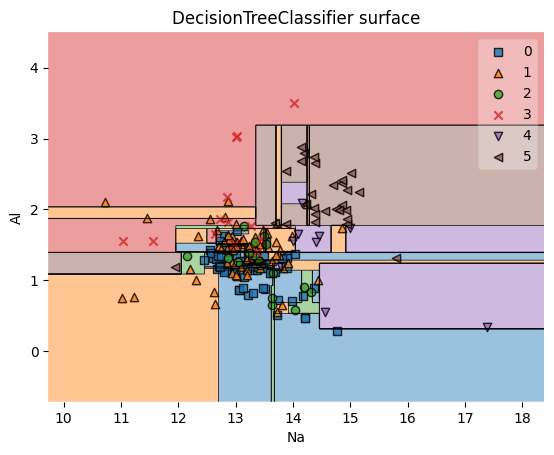

In [9]:
sk_tree_clf = DecisionTreeClassifier(random_state=0)
sk_tree_clf.fit(X1_train, y1_train)
tree_pred_res = sk_tree_clf.predict(X1_test)
tree_accuracy = accuracy_score(tree_pred_res, y1_test)
print(f'tree accuracy: {tree_accuracy}')
print(tree_pred_res)

feature_indexes = [1, 3]
title1 = 'DecisionTreeClassifier surface'
decision_boundary_plot(X1, y1, X1_train, y1_train, sk_tree_clf, feature_indexes, title1)

**VotingClassifier**

voting_clf accuracy: 0.6111111111111112
[5 0 1 1 3 1 0 1 1 1 1 2 1 1 1 5 2 1 0 1 3 0 5 3 0 0 5 0 0 1 0 0 1 2 0 0 0
 2 0 5 3 4 1 0 1 1 0 1 0 1 0 4 5 2]


/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


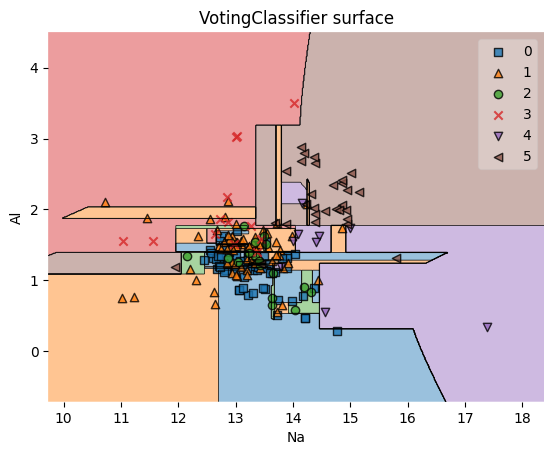

In [10]:
estimators = [('lr', LogisticRegression(random_state=0, max_iter=10000)),
              ('dt', DecisionTreeClassifier(random_state=0)),
              ('svc', SVC(probability=True, random_state=0))]

voting_clf = VotingClassifier(estimators, voting='soft')
voting_clf.fit(X1_train, y1_train)
voting_clf_pred_res = voting_clf.predict(X1_test)
voting_clf_accuracy = accuracy_score(voting_clf_pred_res, y1_test)
print(f'voting_clf accuracy: {voting_clf_accuracy}')
print(voting_clf_pred_res)

feature_indexes = [1, 3]
title2 = 'VotingClassifier surface'
decision_boundary_plot(X1, y1, X1_train, y1_train, voting_clf, feature_indexes, title2)

**BaggingClassifier**

bagging_clf accuracy: 0.6851851851851852
[5 0 1 4 3 1 0 1 1 1 1 0 1 1 1 5 2 1 0 1 3 0 5 5 0 0 5 0 1 1 0 0 1 0 1 0 0
 0 0 5 5 4 1 0 1 1 0 1 0 1 0 4 5 0]


/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


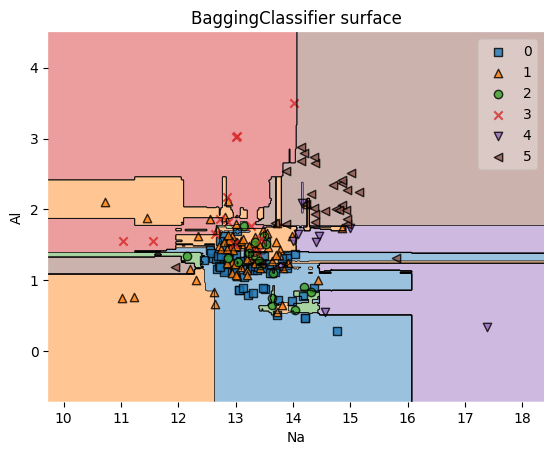

In [11]:
dt_clf = DecisionTreeClassifier(random_state=0)
bagging_clf = BaggingClassifier(estimator=dt_clf, n_estimators=100, random_state=0)
bagging_clf.fit(X1_train, y1_train)
bagging_pred_res = bagging_clf.predict(X1_test)
bagging_clf_accuracy = accuracy_score(bagging_pred_res, y1_test)
print(f'bagging_clf accuracy: {bagging_clf_accuracy}')
print(bagging_pred_res)

feature_indexes = [1, 3]
title3 = 'BaggingClassifier surface'
decision_boundary_plot(X1, y1, X1_train, y1_train, bagging_clf, feature_indexes, title3)

**RandomForestClassifier**

0.7037037037037037


/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


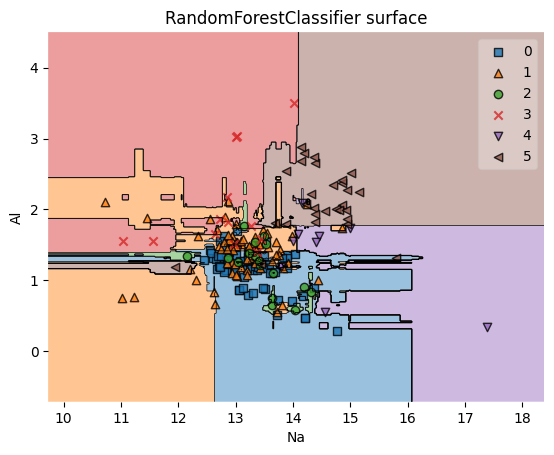

In [12]:
sk_rf_clf = sk_random_forest_classifier
print(sk_rf_clf_accuracy)

feature_indexes = [1, 3]
title4 = 'RandomForestClassifier surface'
decision_boundary_plot(X1, y1, X1_train, y1_train, sk_rf_clf, feature_indexes, title4)

**ExtraTreesClassifier**

et_clf accuracy: 0.7222222222222222
[5 0 1 4 3 1 0 1 1 1 1 0 1 1 1 5 0 1 2 1 3 0 5 5 0 0 5 0 1 1 0 0 1 0 0 0 0
 0 0 5 1 4 1 0 1 1 0 1 0 1 0 1 5 0]


/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


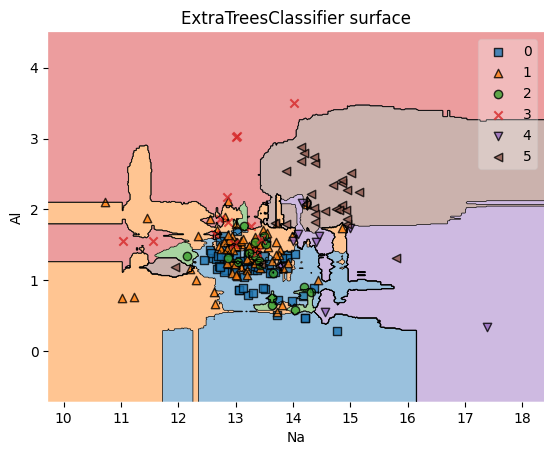

In [13]:
extra_trees_clf = ExtraTreesClassifier(random_state=0)
extra_trees_clf.fit(X1_train, y1_train)
et_clf_pred_res = extra_trees_clf.predict(X1_test)
et_clf_accuracy = accuracy_score(et_clf_pred_res, y1_test)
print(f'et_clf accuracy: {et_clf_accuracy}')
print(et_clf_pred_res)

feature_indexes = [1, 3]
title5 = 'ExtraTreesClassifier surface'
decision_boundary_plot(X1, y1, X1_train, y1_train, extra_trees_clf, feature_indexes, title5)

### **Pros and cons of random forest**
Pros:
- high accuracy of predictions, often comparable to boostings;
- resistance to outliers and unbalanced datasets;
- high speed and good scalability;
- the possibility of clustering;
- works well with skips;
- often resistant to overfitting.

Cons:
- more complex interpretability of the results in comparison with a decision tree;
- a tendency to overfitting on highly noisy data;
- bias towards categorical features with a large number of unique classes: trees will adapt more strongly to these features due to higher information gain.

### **Additional sources**
Paper «RANDOM FORESTS», Leo Breiman.

Documentation:
- [ensembles description](https://scikit-learn.org/stable/modules/ensemble.html#);
- [VotingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html);
- [VotingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingRegressor.html);
- [BaggingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html);
- [BaggingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor);
- [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html);
- [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html);
- [ExtraTreesClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html);
- [ExtraTreesRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html).

Lectures:
- [one](https://www.youtube.com/watch?v=AategB38Zqc);
- [two](https://www.youtube.com/watch?v=YJcv5hWoGSI).

Step-by-step construction of Random Forest:
- [one](https://www.youtube.com/playlist?list=PLPOTBrypY74y0DviMOagKRUhDdk0JyM_r);
- [two](https://www.youtube.com/watch?v=J4Wdy0Wc_xQ&t=94s&ab_channel=StatQuestwithJoshStarmer);
- [three](https://www.youtube.com/watch?v=sQ870aTKqiM&t=254s&ab_channel=StatQuestwithJoshStarmer).